## BMENE4460 Final Project
### Eugénie Dulout & Antoine Andurao

**VGG 1/3 slices on OASIS-1**

This notebook contains our first experiement with VGG on the OASIS-1 dataset. We ended up not using these scripts because the dataset was far too small.

In this file, the input was a [3, 224, 224] Tensor, each channel being a the same coronal slice from the same MRI (the same image is stacked 3 times because VGG was pretrained on color images).


## DATA DOWNLOAD

In [ ]:
import requests
import tarfile
import os
import shutil
import pandas as pd
from PIL import Image
import nibabel as nib
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
  # Path to the .tar.gz file and extraction directory
  extraction_directory = '/content/drive/MyDrive/BMENE4460/Final Project/data/'

In [ ]:
main_path = '/content/drive/.shortcut-targets-by-id/1mnULKQNvITDFX2l9TRHDPv4dMyuUJarb/'
extraction_directory =  '/content/drive/.shortcut-targets-by-id/1mnULKQNvITDFX2l9TRHDPv4dMyuUJarb/Final Project/data/'

In [ ]:
# URL of the OASIS-1 dataset tar.gz file
for i in range(6, 13):
  tar_url = 'https://download.nrg.wustl.edu/data/oasis_cross-sectional_disc' + str(i) + '.tar.gz'
  tar_file_path = main_path + 'Final Project/oasis-1_dataset_part.tar.gz'

  # Download the .tar.gz file
  response = requests.get(tar_url, stream=True)
  if response.status_code == 200:
      with open(tar_file_path, 'wb') as f:
          f.write(response.raw.read())

  # Extract the .tar.gz file
  with tarfile.open(tar_file_path, "r:gz") as tar:
      tar.extractall(path=extraction_directory)

  for item in os.listdir(extraction_directory + 'disc' + str(i)):
      # Construct the full path of the current item
      current_item_path = os.path.join(extraction_directory + 'disc' + str(i), item)

      # Construct the destination path in the parent folder
      destination_item_path = os.path.join(extraction_directory, item)

      # Move the item to the parent folder
      shutil.move(current_item_path, destination_item_path)

  # Delete the tarball and the disc folder after use
  os.rmdir(extraction_directory + 'disc' + str(i))
  os.remove(tar_file_path)

In [ ]:
metadata = pd.read_csv( main_path + 'Final Project/oasis_cross-sectional.csv')

In [ ]:
#shutil.rmtree(extraction_directory + 'reduced/coronal/')
os.mkdir(extraction_directory + 'reduced/coronal/')

In [ ]:
path_to_img = extraction_directory + 'OAS1_0004_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0004_MR1_mpr_n4_anon_111_t88_masked_gfc.img'

image = nib.load(path_to_img)
# Access the image data
data = np.squeeze(image.get_fdata())[:,:,:]
#coronal_data = np.rot90(np.transpose(data, (0, 2, 1)), k=1)

#os.mkdir(extraction_directory + 'reduced/' + metadata.ID[i])

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from skimage import exposure
import torch
from torchvision import transforms

my_img = data[:, 114, :]
# Calculate the zoom factors
zoom_factor = [150 / my_img.shape[0], 150 / my_img.shape[1]]

# Apply bicubic interpolation using scipy's zoom function
img_np = zoom(my_img, zoom_factor, order=3)

# Normalize the image data to [0, 1] for processing with skimage
img_min = img_np.min()
img_max = img_np.max()
img_np = (img_np - img_min) / (img_max - img_min)

# Apply CLAHE
if img_np.ndim == 3:
    img_np = img_np[0]  # Remove channel dimension for processing

clahe = exposure.equalize_adapthist(
    img_np,
    clip_limit=0.02,
    nbins=256,
    kernel_size=(8, 8)
)

# Rescale back to the original range
clahe = clahe * (img_max - img_min) + img_min

my_tensor = torch.tensor(clahe).unsqueeze(0)

# Rotate the image 90 degrees to the right
my_tensor = torch.rot90(my_tensor, k=1, dims=(1, 2))  # k=1 for 90 degrees rotation

# Apply Gaussian blur
gaussian_blur = transforms.Compose([transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.5, 0.5))])
my_tensor = gaussian_blur(my_tensor)

# Display the rotated and blurred image
plt.imshow(my_tensor.numpy()[0, :, :], cmap='gray')
plt.axis('off')
plt.show()


In [ ]:
n = metadata.shape[0]

for i in range(n):

  path_to_img = extraction_directory + metadata.ID[i] + '/PROCESSED/MPRAGE/T88_111/' + metadata.ID[i] + '_mpr_n4_anon_111_t88_masked_gfc.img'

  if not os.path.isfile(path_to_img):
    path_to_img = extraction_directory + metadata.ID[i] + '/PROCESSED/MPRAGE/T88_111/' + metadata.ID[i] + '_mpr_n3_anon_111_t88_masked_gfc.img'
    if not os.path.isfile(path_to_img):
      path_to_img = extraction_directory + metadata.ID[i] + '/PROCESSED/MPRAGE/T88_111/' + metadata.ID[i] + '_mpr_n6_anon_111_t88_masked_gfc.img'
      if not os.path.isfile(path_to_img):
        path_to_img = extraction_directory + metadata.ID[i] + '/PROCESSED/MPRAGE/T88_111/' + metadata.ID[i] + '_mpr_n8_anon_111_t88_masked_gfc.img'
        if not os.path.isfile(path_to_img):
          path_to_img = extraction_directory + metadata.ID[i] + '/PROCESSED/MPRAGE/T88_111/' + metadata.ID[i] + '_mpr_n5_anon_111_t88_masked_gfc.img'
          if not os.path.isfile(path_to_img):
            path_to_img = extraction_directory + metadata.ID[i] + '/PROCESSED/MPRAGE/T88_111/' + metadata.ID[i] + '_mpr_n7_anon_111_t88_masked_gfc.img'
            if not os.path.isfile(path_to_img):
              path_to_img = extraction_directory + metadata.ID[i] + '/PROCESSED/MPRAGE/T88_111/' + metadata.ID[i] + '_mpr_n9_anon_111_t88_masked_gfc.img'

  image = nib.load(path_to_img)

  # Access the image data
  data = np.squeeze(image.get_fdata())[:,105:115,:] #best slices for hippocampus 105 to 114
  os.mkdir(extraction_directory + 'reduced/coronal/' + metadata.ID[i])

  for j in range(10):
    img = data[:,j,:]
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img = (img * 255).astype(np.uint8)
    (Image.fromarray(img)).save(extraction_directory + 'reduced/' + metadata.ID[i] + '/' + str(j) + '.png')

## **I - DATA LOADING & PREPROCESSING**

In [ ]:
import pandas as pd
import numpy as np
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.io import read_image

from sklearn.metrics import confusion_matrix, accuracy_score

from skimage import exposure

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

Mounted at /content/drive


In [ ]:
# main_path = '/content/drive/.shortcut-targets-by-id/1mnULKQNvITDFX2l9TRHDPv4dMyuUJarb/' #Eugénie
main_path = '/content/drive/My Drive/BMENE4460/' # Antoine

In [ ]:
metadata = pd.read_csv(main_path + 'Final Project/oasis_cross-sectional.csv')

# Patiens with CDR>0 are considered demented
# In the paper, CDR=0.5 is MCI and anything above is AD
# Value of diag: 0 <-> healthy, 1 <-> MSI and 2 <-> AD
def assign_diag(cdr):
    if cdr > 0.5:
        return 2
    elif cdr == 0.5:
        return 1
    else:
        return 0 # NaNs are also considered as CDR=0 so healthy

# Apply the function to the CDR column to create a new 'diag' column
metadata['diag'] = metadata['CDR'].apply(assign_diag)
metadata['diag'].value_counts()

diag
0    336
1     70
2     30
Name: count, dtype: int64

In [ ]:
n_patients = min(metadata['diag'].value_counts()) # Taking the number of patients in the least represented class

# Now let's take as many patients in the other 2 classes, at random
HC_rows = metadata[metadata['diag'] == 0].sample(n=n_patients)
MCI_rows = metadata[metadata['diag'] == 1].sample(n=n_patients)
AD_rows = metadata[metadata['diag'] == 2].sample(n=n_patients)

# In order to prevent data leakage, we want to be sure that a patient
# can have slices either only in training, validation or training set

n_training = (np.floor(0.8*n_patients)).astype(int)

training_df = pd.concat([
    HC_rows[:n_training],
    MCI_rows[:n_training],
    AD_rows[:n_training]
])

training_df = training_df.sample(frac=1).reset_index(drop=True)

testing_df = pd.concat([
    HC_rows[n_training:],
    MCI_rows[n_training:],
    AD_rows[n_training:]
])

testing_df = testing_df.sample(frac=1).reset_index(drop=True)

In [ ]:
images_paths = []
labels = []
n=30
for _, row in metadata.iterrows():
    class_dir = os.path.join(main_path + 'Final Project/data/reduced/', str(row['ID']))
    image_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir)]
    for image_path in image_files:
        images_paths.extend([image_path])
    labels.extend([row['diag']] * len(image_files))

indices = np.where(np.array(labels) == 0)[0]
np.random.shuffle(indices)
labels = [item for idx, item in enumerate(labels) if idx not in indices[10*n:]]
images_paths = [item for idx, item in enumerate(images_paths) if idx not in indices[10*n:]]

indices = np.where(np.array(labels) == 1)[0]
np.random.shuffle(indices)
labels = [item for idx, item in enumerate(labels) if idx not in indices[10*n:]]
images_paths = [item for idx, item in enumerate(images_paths) if idx not in indices[10*n:]]

In [ ]:
values, counts = np.unique(labels, return_counts=True)
print(values)
print(counts)

[0 1 2]
[300 300 300]


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import torch
from torchvision import transforms
from skimage import exposure
from tqdm import tqdm

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, patients_df, transform=None):
        self.transform = transform
        self.labels = []
        self.images = []

        for _, row in tqdm(patients_df.iterrows(), total=len(patients_df), desc='Loading images'):
          class_dir = os.path.join(main_path + 'Final Project/data/reduced/', str(row['ID']))
          image_files = iter(sorted([os.path.join(class_dir, f) for f in os.listdir(class_dir)], key=lambda x: os.path.basename(x)))
          for paths in zip(image_files, image_files, image_files):
            img_tensors = []
            for path in paths:

              # Read the image into a Tensor from file
              tensor = read_image(path)

              # Rotate image by 90° counter-clockwise
              tensor = transforms.functional.rotate(tensor, 90)

              # Apply preprocessing
              tensor = transform(tensor)

              # Append the tensor to the list
              img_tensors.append(tensor.squeeze())
            self.labels.append(row['diag'])
            self.images.append(torch.stack(img_tensors))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

class CLAHE():
    def __init__(self, clip_limit=0.02, tile_grid_size=(8, 8)):
        """
        Initialize CLAHE parameters.
        :param clip_limit: Threshold for contrast limiting.
        :param tile_grid_size: Size of the grid for the histogram equalization.
        """
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):
        """
        Apply CLAHE to a torch Tensor image.
        :param img: The input image torch Tensor.
        :return: Image after CLAHE as a torch Tensor.
        """
        # Ensure the image tensor is on CPU and convert it to numpy
        if isinstance(img, torch.Tensor):
            img = img.cpu()

        img_np = img.numpy()

        # Normalize the image data to [0, 1] for processing with skimage
        img_min = img_np.min()
        img_max = img_np.max()
        img_np = (img_np - img_min) / (img_max - img_min)

        # Apply CLAHE
        if img_np.ndim == 3:
            img_np = img_np[0]  # Remove channel dimension for processing

        clahe = exposure.equalize_adapthist(
            img_np,
            clip_limit=self.clip_limit,
            nbins=256,
            kernel_size=self.tile_grid_size
        )

        # Rescale back to the original range
        clahe = clahe * (img_max - img_min) + img_min

        # Convert back to a tensor
        clahe_tensor = torch.from_numpy(clahe).float()

        # Re-add the channel dimension if it was initially present
        if img.ndim == 3:
            clahe_tensor = clahe_tensor.unsqueeze(0)

        return clahe_tensor

# Transform pipeline using torchvision
transforms_pipeline = transforms.Compose([
    transforms.Resize((150, 150)),
    CLAHE(),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.5, 0.5))
])

In [ ]:
# Create datasets
training_set = ImageDataset(training_df, transform=transforms_pipeline)
train_dataset, val_dataset = random_split(training_set, [0.8, 0.2])

testing_set = ImageDataset(testing_df, transform=transforms_pipeline)

Loading images: 100%|██████████| 18/18 [00:03<00:00,  4.64it/s]


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=3, shuffle=False)
test_loader = DataLoader(testing_set, batch_size=3, shuffle=False)

In [ ]:
import torch
from torchvision import transforms
from skimage import exposure
from tqdm import tqdm

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, images_paths, labels, transform=None, group_by_patient=False):
        self.transform = transform
        self.images = []
        self.labels = labels

        if group_by_patient:
            for patient_paths in tqdm(images_paths, total=len(images_paths), desc="Loading Images"):
                img_tensors = []
                for path in patient_paths:
                    # Rotate the image 90 degrees to the right
                    image = read_image(path)
                    image = transforms.functional.rotate(image, angle=-90)

                    # Convert the image to a tensor
                    tensor = transform(image)

                    # Append the tensor to the list
                    img_tensors.append(tensor.unsqueeze(0))

                self.images.extend(torch.stack(img_tensors)
        else:
            # Load images and labels from DataFrame
            for path in tqdm(images_paths, total=len(images_paths), desc="Loading Images"):
                # Rotate the image 90 degrees to the right
                image = read_image(path)
                image = transforms.functional.rotate(image, angle=90)

                self.images.extend(transform(image).unsqueeze(0))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

class CLAHE():
    def __init__(self, clip_limit=0.02, tile_grid_size=(8, 8)):
        """
        Initialize CLAHE parameters.
        :param clip_limit: Threshold for contrast limiting.
        :param tile_grid_size: Size of the grid for the histogram equalization.
        """
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):
        """
        Apply CLAHE to a torch Tensor image.
        :param img: The input image torch Tensor.
        :return: Image after CLAHE as a torch Tensor.
        """
        # Ensure the image tensor is on CPU and convert it to numpy
        if isinstance(img, torch.Tensor):
            img = img.cpu()

        img_np = img.numpy()

        # Normalize the image data to [0, 1] for processing with skimage
        img_min = img_np.min()
        img_max = img_np.max()
        img_np = (img_np - img_min) / (img_max - img_min)

        # Apply CLAHE
        if img_np.ndim == 3:
            img_np = img_np[0]  # Remove channel dimension for processing

        clahe = exposure.equalize_adapthist(
            img_np,
            clip_limit=self.clip_limit,
            nbins=256,
            kernel_size=self.tile_grid_size
        )

        # Rescale back to the original range
        clahe = clahe * (img_max - img_min) + img_min

        # Convert back to a tensor
        clahe_tensor = torch.from_numpy(clahe).float()

        # Re-add the channel dimension if it was initially present
        if img.ndim == 3:
            clahe_tensor = clahe_tensor.unsqueeze(0)

        return clahe_tensor

# Transform pipeline using torchvision
transforms_pipeline = transforms.Compose([
    transforms.Rotate(-90),
    transforms.Resize((150, 150)),
    CLAHE(),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.5, 0.5))
])


In [ ]:
# Create dataset and dataloader
dataset = ImageDataset(images_paths, labels, transform=transforms_pipeline)
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.64, 0.16, 0.2])

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False, num_workers=2)

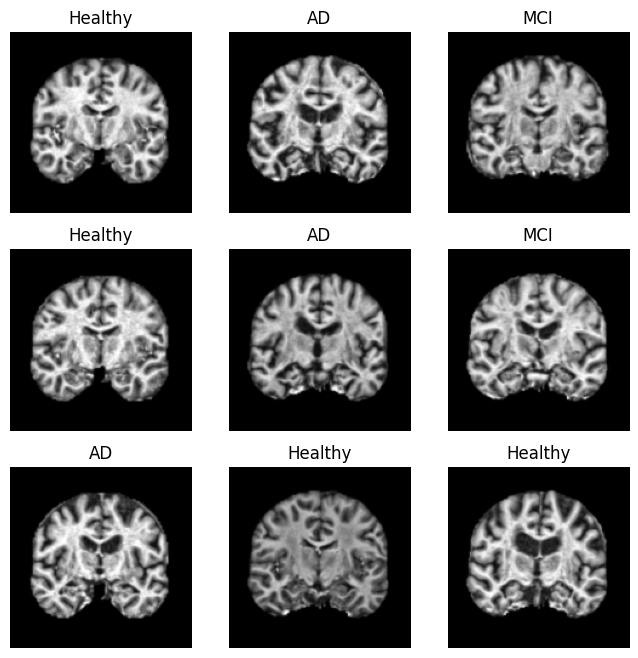

In [ ]:
labels_map = {
    0: "Healthy",
    1: "MCI",
    2: "AD"
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img[0, :, :], cmap="gray")
plt.show()

## **III - MODEL**

In [ ]:
class VGG11(nn.Module):
    def __init__(self, in_channels=3, num_classes=3):
        super(VGG11, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        # convolutional layers
        self.conv_layers = nn.Sequential(

            # Block 1
            nn.Conv2d(self.in_channels, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),  # Adding dropout

            # Block 2
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),  # Adding dropout

            # Block 3
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),  # Adding dropout

            # Block 4
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),  # Adding dropout

            # Block 5
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)  # Adding dropout
        )
        # fully connected linear layers
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=64*4*4, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=self.num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)

        # Flatten size adjusted according to the input size changes
        x = x.view(x.size(0), -1)

        x = self.linear_layers(x)
        return F.log_softmax(x, dim=1)

In [ ]:
# Instantiate your VGG model
our_VGG = VGG11()
our_VGG.to(device)

VGG11(
  (conv_layers): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): R

Define our optimizer:


In [ ]:
# define our optimizer
optimizer = torch.optim.Adam(our_VGG.parameters(), lr = 0.01)

Create a folder to save our trained model by the end of each epoch.

In [ ]:
!mkdir saved_models_VGG

Train our model:

In [ ]:
EPOCHS = 25

# Two lists to keep the losses at the end of each epoch.
train_epoch_loss = list()
validation_epoch_loss = list()

for epoch in range(EPOCHS):

    # A list to keep the losses at the end of each iteration (one batch forward and backward process).
    train_loss = list()

    #######################################################
    ################### Training Loop #####################
    #######################################################

    # Set the model to train mode so that the parameters can be updated.
    our_VGG.train()

    for batch_index, (train_image, train_label) in tqdm(enumerate(train_loader), total=len(train_loader), desc="Epoch " + str(epoch)):

        inputs = train_image.to(device)
        labels = train_label.to(device)

        labels_pred = our_VGG(inputs)

        # compute the loss
        loss = F.cross_entropy(labels_pred, labels)
        train_loss.append(loss.cpu().data.item())

        # reset the gradient
        optimizer.zero_grad()
        # backpropagate the loss
        loss.backward()
        # update the parameters
        optimizer.step()

    # Take the average of iteration losses and append it to the epoch losses list
    train_epoch_loss.append(np.mean(train_loss))

    #######################################################
    #################### validation #######################
    #######################################################

    # Set the model to evaluation mode so that parameters are fixed.
    our_VGG.eval()
    validation_loss = list()
    for batch_index, (val_image, val_label) in enumerate(val_loader):

        inputs = val_image.to(device)
        labels = val_label.to(device)

        labels_pred = our_VGG(inputs)

        # compute the loss
        loss = F.cross_entropy(labels_pred, labels)
        validation_loss.append(loss.cpu().data.item())

    validation_epoch_loss.append(np.mean(validation_loss))

    # save models
    torch.save(our_VGG.state_dict(), './saved_models_VGG/checkpoint_epoch_%s.pth' % (epoch))

    # Print the epoch loss
    print(f"Epoch: {epoch+1}/{EPOCHS} | Train Loss: {train_epoch_loss[-1]} | Validation Loss: {validation_epoch_loss[-1]}")

Epoch 0: 100%|██████████| 173/173 [00:05<00:00, 33.18it/s]


Epoch: 1/25 | Train Loss: 2.064020617030604 | Validation Loss: 1.0788345988406691


Epoch 1: 100%|██████████| 173/173 [00:03<00:00, 56.30it/s]


Epoch: 2/25 | Train Loss: 1.1221157687936905 | Validation Loss: 1.1053359064944954


Epoch 2: 100%|██████████| 173/173 [00:01<00:00, 156.64it/s]


Epoch: 3/25 | Train Loss: 1.1026710357969207 | Validation Loss: 1.104672526204309


Epoch 3: 100%|██████████| 173/173 [00:01<00:00, 156.59it/s]


Epoch: 4/25 | Train Loss: 1.109521701501284 | Validation Loss: 1.1013342252997464


Epoch 4: 100%|██████████| 173/173 [00:01<00:00, 154.11it/s]


Epoch: 5/25 | Train Loss: 1.1020081504921004 | Validation Loss: 1.1082404158836188


Epoch 5: 100%|██████████| 173/173 [00:01<00:00, 151.83it/s]


Epoch: 6/25 | Train Loss: 1.102009142754395 | Validation Loss: 1.1050064452858859


Epoch 6: 100%|██████████| 173/173 [00:01<00:00, 155.91it/s]


Epoch: 7/25 | Train Loss: 1.102346186693004 | Validation Loss: 1.1130064393198766


Epoch 7: 100%|██████████| 173/173 [00:01<00:00, 154.31it/s]


Epoch: 8/25 | Train Loss: 1.1046350687914501 | Validation Loss: 1.116701367289521


Epoch 8: 100%|██████████| 173/173 [00:01<00:00, 155.74it/s]


Epoch: 9/25 | Train Loss: 1.1013521390154182 | Validation Loss: 1.1109801558561103


Epoch 9: 100%|██████████| 173/173 [00:01<00:00, 138.58it/s]


Epoch: 10/25 | Train Loss: 1.1030784428464195 | Validation Loss: 1.1093029199644577


Epoch 10: 100%|██████████| 173/173 [00:01<00:00, 122.46it/s]


Epoch: 11/25 | Train Loss: 1.104541084669918 | Validation Loss: 1.1084266845570054


Epoch 11: 100%|██████████| 173/173 [00:01<00:00, 102.01it/s]


Epoch: 12/25 | Train Loss: 1.1025612340497144 | Validation Loss: 1.1089865107868992


Epoch 12: 100%|██████████| 173/173 [00:01<00:00, 115.41it/s]


Epoch: 13/25 | Train Loss: 1.1038579003659288 | Validation Loss: 1.1140617215356161


Epoch 13: 100%|██████████| 173/173 [00:01<00:00, 113.47it/s]


Epoch: 14/25 | Train Loss: 1.1027537246660002 | Validation Loss: 1.108987151190292


Epoch 14: 100%|██████████| 173/173 [00:01<00:00, 155.84it/s]


Epoch: 15/25 | Train Loss: 1.1008501817725298 | Validation Loss: 1.1084137267844623


Epoch 15: 100%|██████████| 173/173 [00:01<00:00, 154.30it/s]


Epoch: 16/25 | Train Loss: 1.1027748136851139 | Validation Loss: 1.105387992637102


Epoch 16: 100%|██████████| 173/173 [00:01<00:00, 156.68it/s]


Epoch: 17/25 | Train Loss: 1.1032280577400517 | Validation Loss: 1.1069105392278626


Epoch 17: 100%|██████████| 173/173 [00:01<00:00, 154.84it/s]


Epoch: 18/25 | Train Loss: 1.1039534018218862 | Validation Loss: 1.1048146236774534


Epoch 18: 100%|██████████| 173/173 [00:01<00:00, 157.92it/s]


Epoch: 19/25 | Train Loss: 1.3812662392660888 | Validation Loss: 1.0850874033085136


Epoch 19: 100%|██████████| 173/173 [00:01<00:00, 120.74it/s]


Epoch: 20/25 | Train Loss: 1.1101273691034041 | Validation Loss: 1.116821050643921


Epoch 20: 100%|██████████| 173/173 [00:01<00:00, 113.58it/s]


Epoch: 21/25 | Train Loss: 1.103526877874584 | Validation Loss: 1.1102164290672125


Epoch 21: 100%|██████████| 173/173 [00:01<00:00, 155.03it/s]


Epoch: 22/25 | Train Loss: 1.104579771874268 | Validation Loss: 1.1060825447703517


Epoch 22: 100%|██████████| 173/173 [00:01<00:00, 154.70it/s]


Epoch: 23/25 | Train Loss: 1.1023647881656713 | Validation Loss: 1.1101593305898267


Epoch 23: 100%|██████████| 173/173 [00:01<00:00, 157.33it/s]


Epoch: 24/25 | Train Loss: 1.103311195538912 | Validation Loss: 1.1086131278858629


Epoch 24: 100%|██████████| 173/173 [00:01<00:00, 156.95it/s]


Epoch: 25/25 | Train Loss: 1.103098231588485 | Validation Loss: 1.1048971636350764


In [ ]:
state_dict = torch.load('./saved_models_VGG/checkpoint_epoch_%s.pth' % (np.argmin(validation_epoch_loss)))
print(state_dict.keys())
our_VGG.load_state_dict(state_dict)

odict_keys(['conv_layers.0.weight', 'conv_layers.0.bias', 'conv_layers.1.weight', 'conv_layers.1.bias', 'conv_layers.1.running_mean', 'conv_layers.1.running_var', 'conv_layers.1.num_batches_tracked', 'conv_layers.5.weight', 'conv_layers.5.bias', 'conv_layers.6.weight', 'conv_layers.6.bias', 'conv_layers.6.running_mean', 'conv_layers.6.running_var', 'conv_layers.6.num_batches_tracked', 'conv_layers.10.weight', 'conv_layers.10.bias', 'conv_layers.11.weight', 'conv_layers.11.bias', 'conv_layers.11.running_mean', 'conv_layers.11.running_var', 'conv_layers.11.num_batches_tracked', 'conv_layers.13.weight', 'conv_layers.13.bias', 'conv_layers.14.weight', 'conv_layers.14.bias', 'conv_layers.14.running_mean', 'conv_layers.14.running_var', 'conv_layers.14.num_batches_tracked', 'conv_layers.18.weight', 'conv_layers.18.bias', 'conv_layers.19.weight', 'conv_layers.19.bias', 'conv_layers.19.running_mean', 'conv_layers.19.running_var', 'conv_layers.19.num_batches_tracked', 'conv_layers.21.weight', 'c

<All keys matched successfully>

In [ ]:
test_accuracy_batch = list()
CM = np.zeros((3, 3), dtype=int)

for batch_index, (test_image, test_label) in enumerate(test_loader):

    label_pred = our_VGG(test_image.to(device))
    _, label_predicted_index = torch.max(label_pred.data, 1)
    test_accuracy_batch.append(accuracy_score(label_predicted_index.detach().cpu().numpy(), test_label.detach().cpu().numpy()))
    CM = CM + confusion_matrix(label_predicted_index.detach().cpu().numpy(), test_label.detach().cpu().numpy(), labels=[0, 1, 2])

print("Accuracy:", np.mean(test_accuracy_batch) * 100, "%")

Accuracy: 33.33333333333333 %


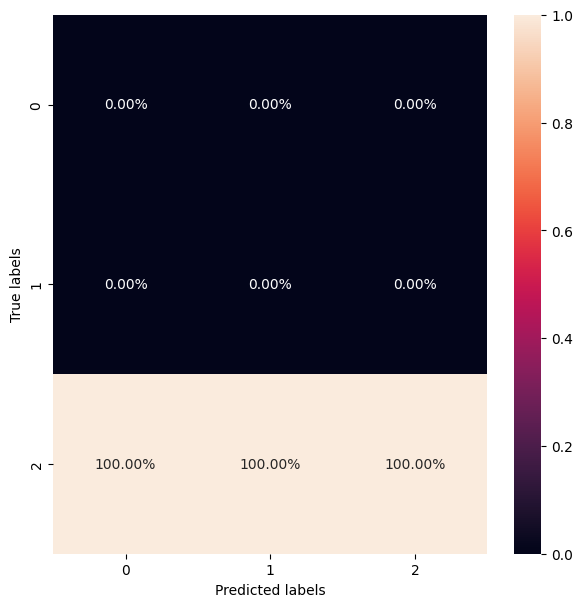

In [ ]:
plt.figure(figsize = (7,7))
sns.heatmap(CM/np.sum(CM, axis=0), annot = True, fmt='.2%', xticklabels=labels_map, yticklabels=labels_map)
plt.ylabel('True labels');
plt.xlabel('Predicted labels');

# **VGG FOR 1 SLICE AT A TIME**

In [ ]:
import shutil
import os
# Delete the directory if it exists
if os.path.exists("saved_models_VGG3"):
    shutil.rmtree("saved_models_VGG3")

# Recreate the directory
os.mkdir("saved_models_VGG3")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg11
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_curve, auc

class VGG3(nn.Module):
    def __init__(self, in_channels=1, num_classes=3):
        super(VGG3, self).__init__()
        self.num_classes = num_classes
        self.vgg = vgg11(pretrained=False, progress=True)
        self.vgg.features[0] = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.vgg.classifier[6] = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.vgg(x)
        return F.log_softmax(x, dim=1)

def compute_heatmap(model, image):
    model.eval()
    image = image.to(device)
    image.requires_grad = True
    with torch.set_grad_enabled(True):
        output = model(image.unsqueeze(0))
        predicted_class = torch.argmax(output, dim=1)
        model.vgg.classifier[6].weight.grad = None
        output[:, predicted_class].backward()

        heatmap = image.grad.squeeze().abs().detach().cpu().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
    return heatmap

def plot_heatmap(image, heatmap, title):
    plt.imshow(image.squeeze(), cmap='gray')
    plt.imshow(heatmap, alpha=0.6, cmap='jet')
    plt.colorbar()
    plt.title(title)
    plt.axis('off')
    plt.show()

def train(model, train_loader, val_loader, optimizer, criterion, device, epochs=10):
    train_losses = []
    val_losses = []
    f1_scores = []
    accuracies = []
    recalls = []
    precisions = []

    best_val_loss = float('inf')
    best_epoch = 0

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        predictions = []
        true_labels = []

        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            with torch.no_grad():
                output = model(images)
                loss = criterion(output, labels)
                val_loss += loss.item() * images.size(0)

                predicted_labels = torch.argmax(output, dim=1)
                predictions.extend(predicted_labels.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Calculate metrics
        f1 = f1_score(true_labels, predictions)
        accuracy = accuracy_score(true_labels, predictions)
        recall = recall_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions)

        f1_scores.append(f1)
        accuracies.append(accuracy)
        recalls.append(recall)
        precisions.append(precision)

        print(f"Epoch {epoch}/{epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch

    print(f"Best epoch: {best_epoch}")

    # Plot loss and validation curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot ROC curve and calculate AUC
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    auc_score = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Select best model based on best_epoch
    return best_epoch

# Assuming train_loader, test_loader, and val_loader are defined elsewhere
# Assuming device is defined and torch.cuda.is_available() returns True if GPU is available, else False

# Define your VGG model
our_VGG = VGG3()
our_VGG.to(device)

# Define your optimizer and loss function
optimizer = torch.optim.Adam(our_VGG.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train your model
best_epoch = train(our_VGG, train_loader, val_loader, optimizer, criterion, device, epochs=25)

# Select best model based on best_epoch
print(f"Best epoch: {best_epoch}")


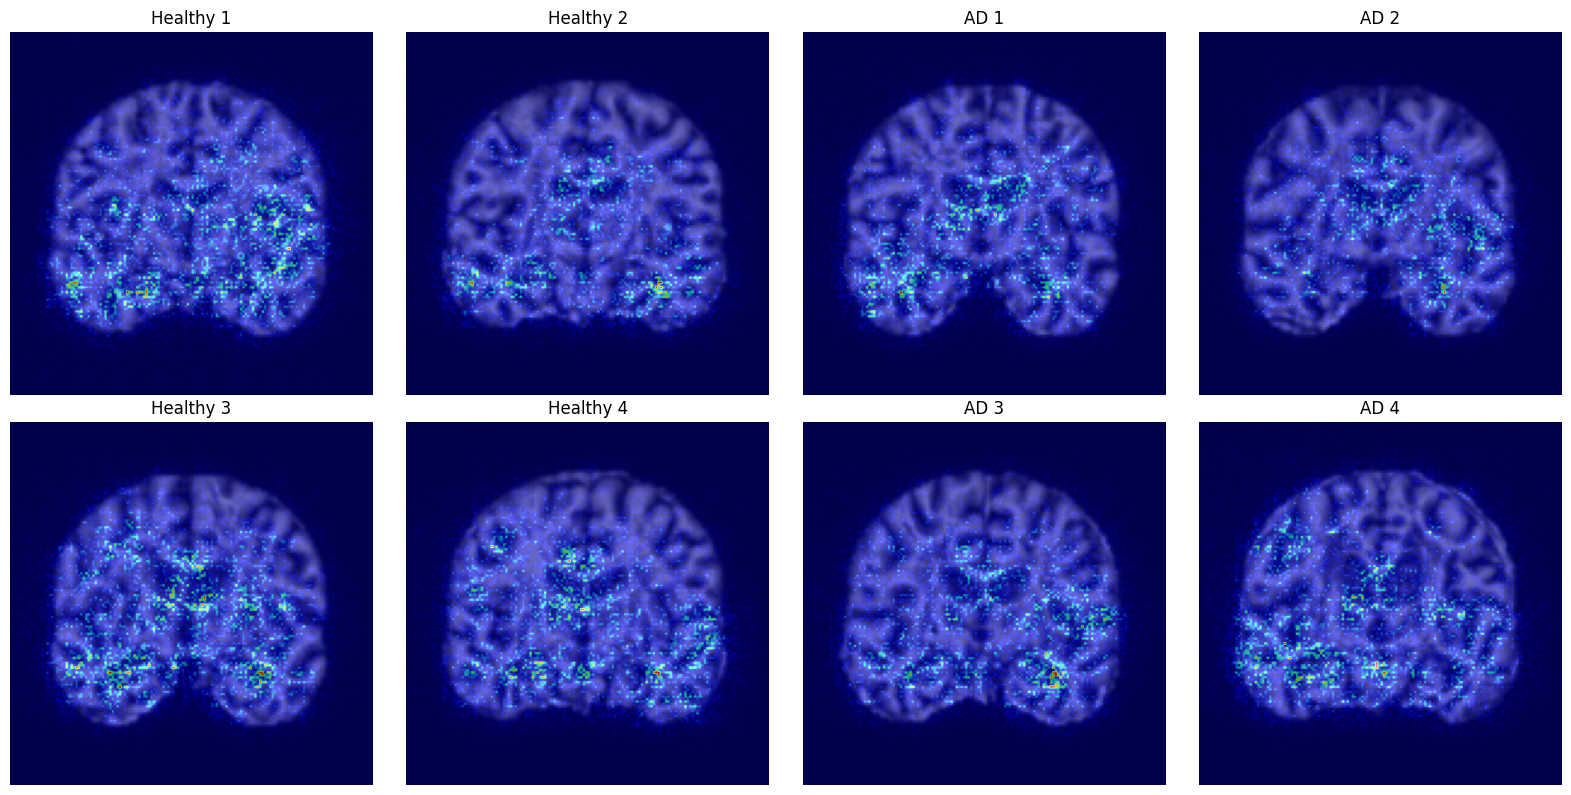

In [ ]:
# Plot heatmap for 4 AD brains and 4 healthy brains using the best model
ad_images = []
mci_images = []
healthy_images = []
for images, labels in val_loader:
    ad_images.extend(images[labels == 2])  # Class 1 represents AD patients
    mci_images.extend(images[labels == 1])
    healthy_images.extend(images[labels == 0])  # Class 0 represents healthy patients
ad_images = ad_images[:4]
mci_images = mci_images[:4]
healthy_images = healthy_images[:4]

# Plot heatmap for healthy and AD brains using the best model
fig, axes = plt.subplots(3, 4, figsize=(16, 8))

# Plot healthy brains
for i, image in enumerate(healthy_images[:4]):
    heatmap = compute_heatmap(our_VGG, image)
    ax = axes[i // 2, i % 2].imshow(image.cpu().detach().squeeze(), cmap='gray')
    ax = axes[i // 2, i % 2].imshow(heatmap, alpha=0.6, cmap='jet')
    axes[i // 2, i % 2].set_title(f'Healthy {i+1}', fontsize=12)
    axes[i // 2, i % 2].axis('off')

# Plot MCI brains
for i, image in enumerate(mci_images[:4]):
    heatmap = compute_heatmap(our_VGG, image)
    ax = axes[i // 2, (i % 2) + 2].imshow(image.cpu().detach().squeeze(), cmap='gray')
    ax = axes[i // 2, (i % 2) + 2].imshow(heatmap, alpha=0.6, cmap='jet')
    axes[i // 2, (i % 2) + 2].set_title(f'AD {i+1}', fontsize=12)
    axes[i // 2, (i % 2) + 2].axis('off')

# Plot AD brains
for i, image in enumerate(ad_images[:4]):
    heatmap = compute_heatmap(our_VGG, image)
    ax = axes[i // 2, (i % 2) + 2].imshow(image.cpu().detach().squeeze(), cmap='gray')
    ax = axes[i // 2, (i % 2) + 2].imshow(heatmap, alpha=0.6, cmap='jet')
    axes[i // 2, (i % 2) + 2].set_title(f'AD {i+1}', fontsize=12)
    axes[i // 2, (i % 2) + 2].axis('off')

plt.tight_layout()
plt.show()


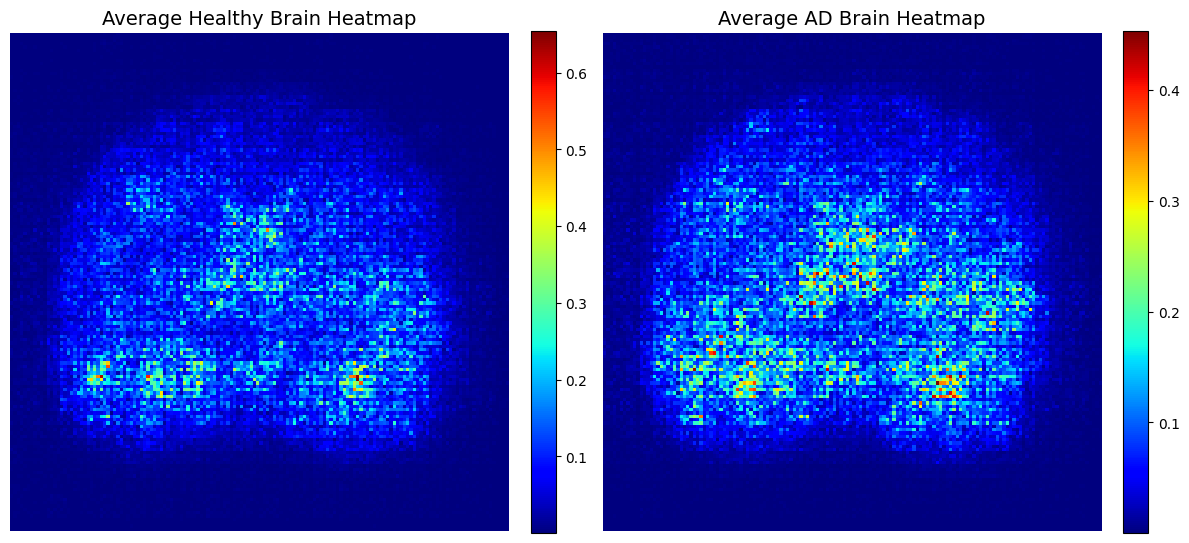

In [ ]:
# Compute average heatmap for healthy brains
healthy_heatmaps = []
for image in healthy_images:
    heatmap = compute_heatmap(our_VGG, image)
    healthy_heatmaps.append(heatmap)

average_healthy_heatmap = np.mean(healthy_heatmaps, axis=0)

# Compute average heatmap for MCI brains
mci_heatmaps = []
for image in mci_images:
    heatmap = compute_heatmap(our_VGG, image)
    mci_heatmaps.append(heatmap)

average_mci_heatmap = np.mean(mci_heatmaps, axis=0)

# Compute average heatmap for Alzheimer's brains
ad_heatmaps = []
for image in ad_images:
    heatmap = compute_heatmap(our_VGG, image)
    ad_heatmaps.append(heatmap)

average_ad_heatmap = np.mean(ad_heatmaps, axis=0)

# Plot the average heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot average healthy heatmap
healthy_im = axes[0].imshow(average_healthy_heatmap, cmap='jet')
axes[0].set_title('Average Healthy Brain Heatmap', fontsize=14)
axes[0].axis('off')
plt.colorbar(healthy_im, ax=axes[0], fraction=0.046, pad=0.04)

# Plot average healthy heatmap
mci_im = axes[0].imshow(average_mci_heatmap, cmap='jet')
axes[0].set_title('Average MCI Brain Heatmap', fontsize=14)
axes[0].axis('off')
plt.colorbar(mci_im, ax=axes[0], fraction=0.046, pad=0.04)

# Plot average Alzheimer's heatmap
ad_im = axes[1].imshow(average_ad_heatmap, cmap='jet')
axes[1].set_title('Average AD Brain Heatmap', fontsize=14)
axes[1].axis('off')
plt.colorbar(ad_im, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()



In [ ]:
from scipy.stats import ttest_ind

# Flatten the heatmaps to perform the t-test
flattened_healthy_heatmaps = average_healthy_heatmap.flatten()
flattened_mci_heatmaps = average_mci_heatmap.flatten()
flattened_ad_heatmaps = average_ad_heatmap.flatten()

# Perform t-test
t_statistic, p_value = ttest_ind(flattened_healthy_heatmaps, flattened_mci_heatmaps, flattened_ad_heatmaps)

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")


T-statistic: 6.962266264244871
P-value: 3.3941947535823957e-12


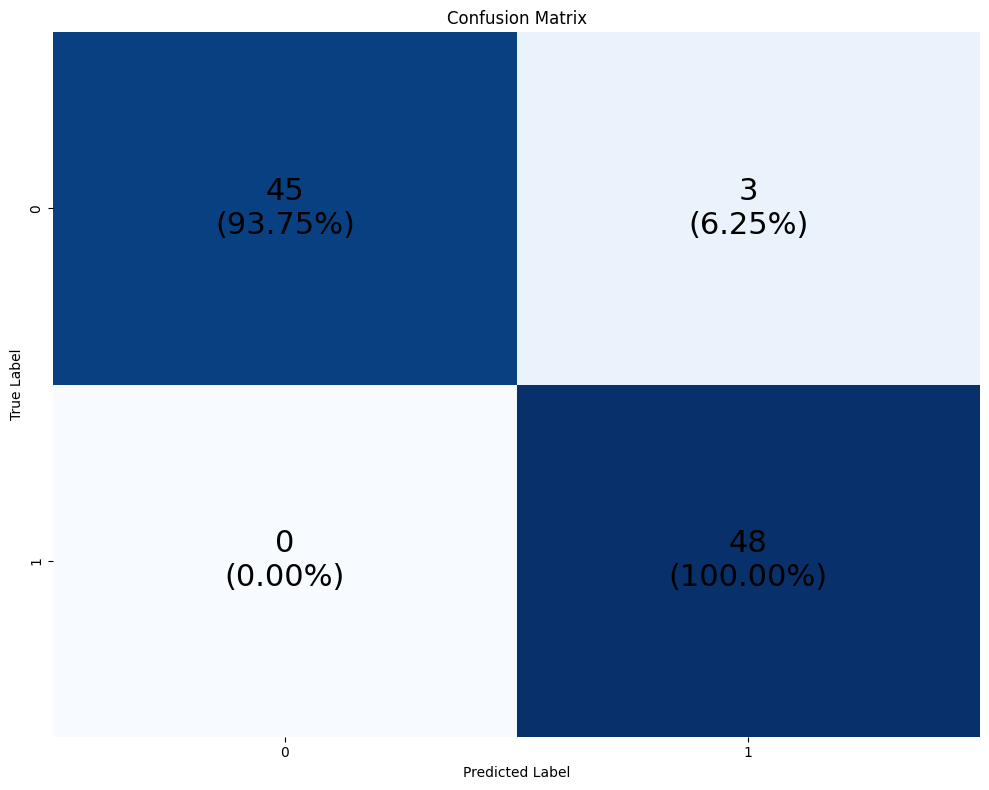

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))

# Plot absolute values and percentages
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        correct_samples = conf_matrix[i, j]
        actual_correct_samples = np.sum(conf_matrix[i])
        percentage = (correct_samples / actual_correct_samples) * 100
        text = f"{correct_samples}\n({percentage:.2f}%)"
        plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black', fontsize=22)

sns.heatmap(conf_matrix, annot=False, cmap="Blues", cbar=False, fmt="")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()


# **VGG FOR 3 SLICES AT A TIME**

In [ ]:
import shutil
import os
# Delete the directory if it exists
if os.path.exists("saved_models_VGG11"):
    shutil.rmtree("saved_models_VGG11")

# Recreate the directory
os.mkdir("saved_models_VGG11")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg11
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_curve, auc

class VGG11(nn.Module):
    def __init__(self, in_channels=3, num_classes=3):
        super(VGG11, self).__init__()
        self.num_classes = num_classes
        self.vgg = vgg11(weights='IMAGENET1K_V1')

    def forward(self, x):
        x = self.vgg(x)
        return F.log_softmax(x, dim=1)

def compute_heatmaps(model, stacked_images):
    model.eval()
    stacked_images = stacked_images.to(device)
    stacked_images.requires_grad = True
    heatmaps = []
    with torch.set_grad_enabled(True):
        output = model(stacked_images)
        predicted_classes = torch.argmax(output, dim=1)

        for i in range(stacked_images.size(0)):
            model.zero_grad()
            output[i, predicted_classes[i]].backward(retain_graph=True)
            heatmap = stacked_images.grad[i].abs().detach().cpu().numpy()
            heatmap = np.maximum(heatmap, 0)
            heatmap /= np.max(heatmap)
            heatmaps.append(heatmap)

    return heatmaps

def plot_heatmaps(original_images, heatmaps):
    for i, (image, heatmap) in enumerate(zip(original_images, heatmaps)):
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image.permute(1, 2, 0).cpu().numpy())
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(image.permute(1, 2, 0).cpu().numpy())
        plt.imshow(heatmap.max(axis=0), alpha=0.6, cmap='jet')  # max over color channels
        plt.colorbar()
        plt.title(f'Heatmap for Image {i+1}')
        plt.axis('off')
        plt.show()

def train(model, train_loader, val_loader, optimizer, criterion, device, epochs=10):
    train_losses = []
    val_losses = []
    f1_scores = []
    accuracies = []
    recalls = []
    precisions = []

    best_val_loss = float('inf')
    best_epoch = 0

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        predictions = []
        true_labels = []

        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            with torch.no_grad():
                output = model(images)
                loss = criterion(output, labels)
                val_loss += loss.item() * images.size(0)

                predicted_labels = torch.argmax(output, dim=1)
                predictions.extend(predicted_labels.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Calculate metrics
        accuracy = accuracy_score(true_labels, predictions)

        # f1_scores.append(f1)
        accuracies.append(accuracy)

        print(f"Epoch {epoch}/{epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Accuracy: {accuracy:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch

    print(f"Best epoch: {best_epoch}")

    # Plot loss and validation curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Select best model based on best_epoch
    return best_epoch

Epoch 1/25:
Train Loss: 15.9053, Val Loss: 1.5374
Accuracy: 0.3488
Epoch 2/25:
Train Loss: 1.2449, Val Loss: 1.1305
Accuracy: 0.3953
Epoch 3/25:
Train Loss: 1.2084, Val Loss: 1.1133
Accuracy: 0.3488
Epoch 4/25:
Train Loss: 1.2126, Val Loss: 1.0923
Accuracy: 0.3953
Epoch 5/25:
Train Loss: 1.1554, Val Loss: 1.1074
Accuracy: 0.3488
Epoch 6/25:
Train Loss: 1.1145, Val Loss: 1.2984
Accuracy: 0.3488
Epoch 7/25:
Train Loss: 1.1797, Val Loss: 1.1797
Accuracy: 0.2558
Epoch 8/25:
Train Loss: 1.1368, Val Loss: 1.0959
Accuracy: 0.3488
Epoch 9/25:
Train Loss: 1.1523, Val Loss: 1.1541
Accuracy: 0.2558
Epoch 10/25:
Train Loss: 1.1310, Val Loss: 1.1469
Accuracy: 0.2558
Epoch 11/25:
Train Loss: 1.1605, Val Loss: 1.1078
Accuracy: 0.2558
Epoch 12/25:
Train Loss: 1.1275, Val Loss: 1.1255
Accuracy: 0.3953
Epoch 13/25:
Train Loss: 1.1531, Val Loss: 1.1354
Accuracy: 0.3953
Epoch 14/25:
Train Loss: 1.1654, Val Loss: 1.0967
Accuracy: 0.3488
Epoch 15/25:
Train Loss: 1.1213, Val Loss: 1.1535
Accuracy: 0.3488
Epo

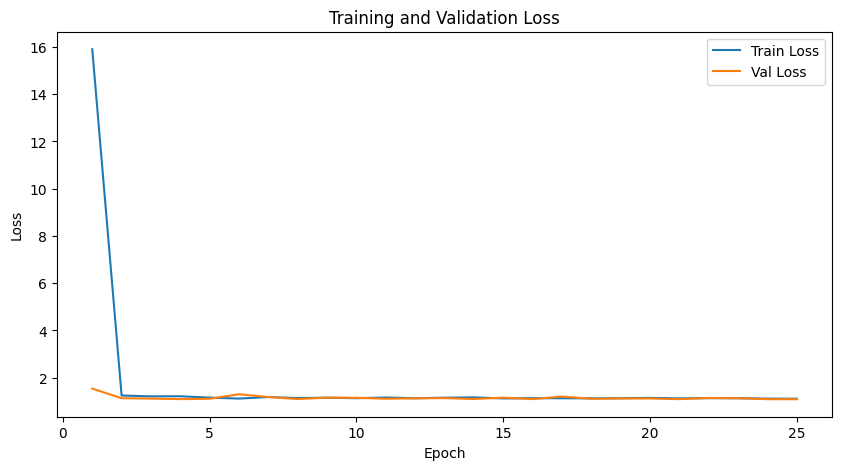

Best epoch: 25


In [ ]:
# Define your VGG model
our_VGG = VGG11()
our_VGG.to(device)

# Define your optimizer and loss function
optimizer = torch.optim.Adam(our_VGG.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train your model
best_epoch = train(our_VGG, train_loader, val_loader, optimizer, criterion, device, epochs=25)

# Select best model based on best_epoch
print(f"Best epoch: {best_epoch}")

torch.Size([3, 150, 150])


<ipython-input-37-6efea6429bd1>:34: RuntimeWarning: divide by zero encountered in divide
  heatmap /= np.max(heatmap)
<ipython-input-37-6efea6429bd1>:34: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

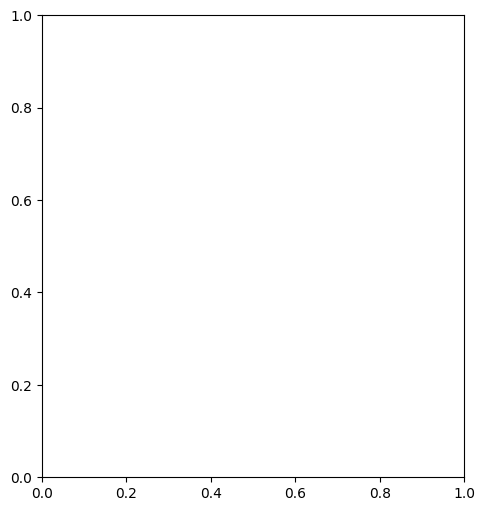

In [ ]:
'''
# Plot heatmap for 4 AD brains and 4 healthy brains using the best model
ad_images = []
mci_images = []
healthy_images = []
for images, labels in val_loader:
    ad_images.extend(images[labels == 2])  # Class 1 represents AD patients
    mci_images.extend(images[labels == 1])
    healthy_images.extend(images[labels == 0])  # Class 0 represents healthy patients
ad_images = ad_images[:4]
mci_images = mci_images[:4]
healthy_images = healthy_images[:4]

# Plot heatmap for healthy and AD brains using the best model
fig, axes = plt.subplots(3, 4, figsize=(16, 8))

# Plot healthy brains
for i, image in enumerate(healthy_images[:4]):
    heatmap = compute_heatmap(our_VGG, image)
    ax = axes[i // 2, i % 2].imshow(image.cpu().detach()[0], cmap='gray')
    ax = axes[i // 2, i % 2].imshow(heatmap, alpha=0.6, cmap='jet')
    axes[i // 2, i % 2].set_title(f'Healthy {i+1}', fontsize=12)
    axes[i // 2, i % 2].axis('off')

# Plot MCI brains
for i, image in enumerate(mci_images[:4]):
    heatmap = compute_heatmap(our_VGG, image)
    ax = axes[i // 2, (i % 2) + 2].imshow(image.cpu().detach()[0], cmap='gray')
    ax = axes[i // 2, (i % 2) + 2].imshow(heatmap, alpha=0.6, cmap='jet')
    axes[i // 2, (i % 2) + 2].set_title(f'AD {i+1}', fontsize=12)
    axes[i // 2, (i % 2) + 2].axis('off')

# Plot AD brains
for i, image in enumerate(ad_images[:4]):
    heatmap = compute_heatmap(our_VGG, image)
    ax = axes[i // 2, (i % 2) + 2].imshow(image.cpu().detach()[0], cmap='gray')
    ax = axes[i // 2, (i % 2) + 2].imshow(heatmap, alpha=0.6, cmap='jet')
    axes[i // 2, (i % 2) + 2].set_title(f'AD {i+1}', fontsize=12)
    axes[i // 2, (i % 2) + 2].axis('off')

plt.tight_layout()
plt.show()
'''

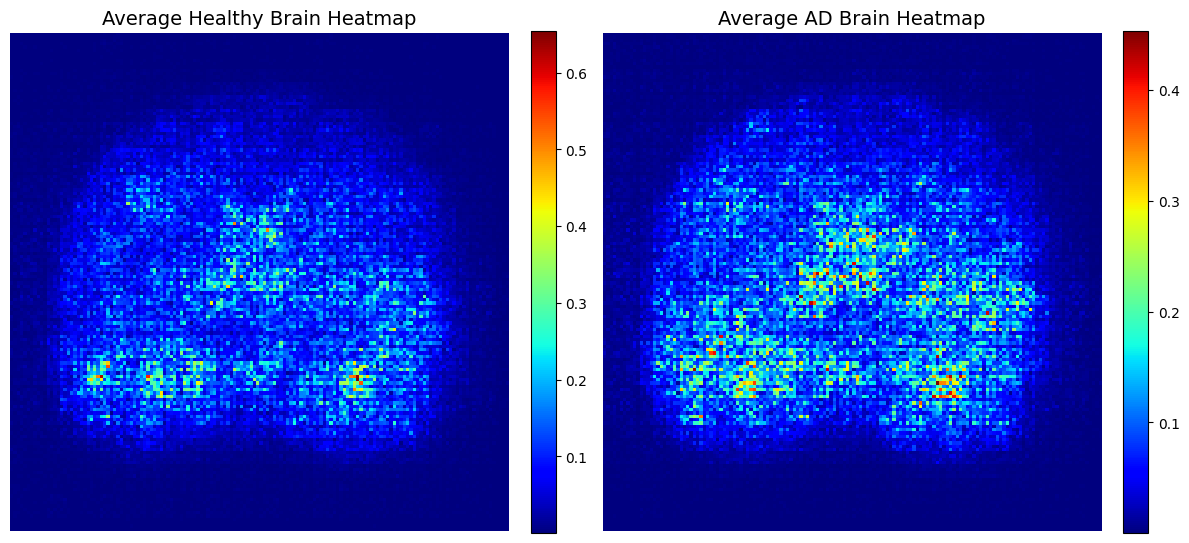

In [ ]:
# Compute average heatmap for healthy brains
healthy_heatmaps = []
for image in healthy_images:
    heatmap = compute_heatmap(our_VGG, image)
    healthy_heatmaps.append(heatmap)

average_healthy_heatmap = np.mean(healthy_heatmaps, axis=0)

# Compute average heatmap for MCI brains
mci_heatmaps = []
for image in mci_images:
    heatmap = compute_heatmap(our_VGG, image)
    mci_heatmaps.append(heatmap)

average_mci_heatmap = np.mean(mci_heatmaps, axis=0)

# Compute average heatmap for Alzheimer's brains
ad_heatmaps = []
for image in ad_images:
    heatmap = compute_heatmap(our_VGG, image)
    ad_heatmaps.append(heatmap)

average_ad_heatmap = np.mean(ad_heatmaps, axis=0)

# Plot the average heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot average healthy heatmap
healthy_im = axes[0].imshow(average_healthy_heatmap, cmap='jet')
axes[0].set_title('Average Healthy Brain Heatmap', fontsize=14)
axes[0].axis('off')
plt.colorbar(healthy_im, ax=axes[0], fraction=0.046, pad=0.04)

# Plot average healthy heatmap
mci_im = axes[0].imshow(average_mci_heatmap, cmap='jet')
axes[0].set_title('Average MCI Brain Heatmap', fontsize=14)
axes[0].axis('off')
plt.colorbar(mci_im, ax=axes[0], fraction=0.046, pad=0.04)

# Plot average Alzheimer's heatmap
ad_im = axes[1].imshow(average_ad_heatmap, cmap='jet')
axes[1].set_title('Average AD Brain Heatmap', fontsize=14)
axes[1].axis('off')
plt.colorbar(ad_im, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()



In [ ]:
from scipy.stats import ttest_ind

# Flatten the heatmaps to perform the t-test
flattened_healthy_heatmaps = average_healthy_heatmap.flatten()
flattened_mci_heatmaps = average_mci_heatmap.flatten()
flattened_ad_heatmaps = average_ad_heatmap.flatten()

# Perform t-test
t_statistic, p_value = ttest_ind(flattened_healthy_heatmaps, flattened_mci_heatmaps, flattened_ad_heatmaps)

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")


T-statistic: 6.962266264244871
P-value: 3.3941947535823957e-12


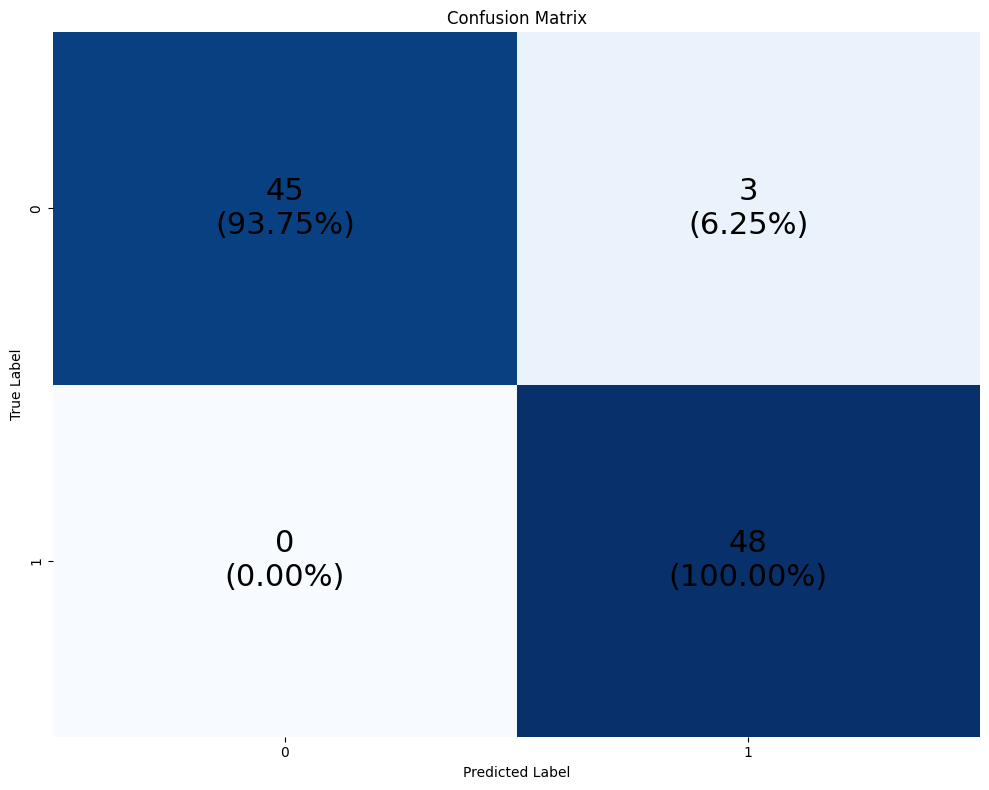

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))

# Plot absolute values and percentages
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        correct_samples = conf_matrix[i, j]
        actual_correct_samples = np.sum(conf_matrix[i])
        percentage = (correct_samples / actual_correct_samples) * 100
        text = f"{correct_samples}\n({percentage:.2f}%)"
        plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black', fontsize=22)

sns.heatmap(conf_matrix, annot=False, cmap="Blues", cbar=False, fmt="")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()
